In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts
import os
import ffn
import talib

In [7]:
TUSHARE_API_KEY = os.environ.get('TUSHARE_API_KEY')
ts_pro = ts.pro_api(TUSHARE_API_KEY)

# 获取股票数据
df = ts_pro.daily(ts_code='600025.SH', start_date='20240514', end_date='20250513', fields='ts_code,trade_date,open,high,low,close,vol')
df.sort_values(by='trade_date', ascending=True, inplace=True) # 确保按时间升序排列
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.to_csv('data/600025.SH.csv', index=False)

# 读取历史数据
df = pd.read_csv('data/600025.SH.csv')
df['RSI'] = talib.RSI(df['close'], timeperiod=14) # 14日RSI

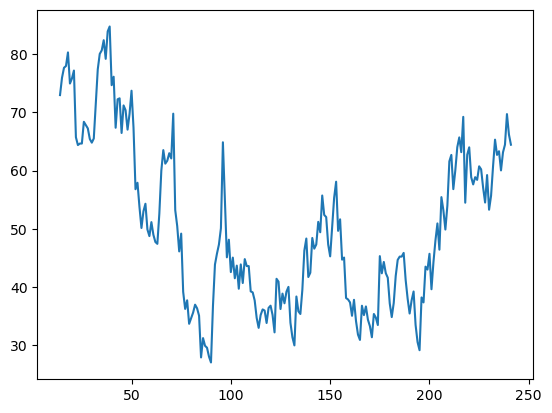

In [9]:
plt.plot(df['RSI'])

In [8]:
# 初始化变量
hold = False # 是否持仓
pos = 0 # 持仓数
cash = 100000 # 初始资金
fee = 0.0003 # 手续费万三
capital_list = [] # 每日资金数列表

for index, row in df.iterrows():
    current_date = row['trade_date']
    price = row['close']
    current_rsi = row['RSI']

    # 跳过无RSI的初期阶段（前14天）
    if pd.isna(current_rsi):
        capital_list.append(cash + pos * price) # 记录总资产
        continue
    
    # 交易信号逻辑
    if current_rsi < 30 and not hold:
        # 计算可买数量（按100股整数倍）
        max_shares = int(cash / (price * (1 + fee)))
        pos = (max_shares // 100) * 100
        if pos > 0:
            cost = pos * price * (1 + fee)
            cash -= cost
            hold = True
            print(f'Buy at {current_date}, price {price:.2f}, pos {pos}')
    elif current_rsi > 70 and hold:
        # 平仓全部头寸
        proceeds = pos * price * (1 - fee)
        cash += proceeds
        pos = 0
        hold = False
        print(f'Sell at {current_date}, price {price:.2f}, proceeds {proceeds:.2f}')
    
    # 记录每日总资产
    capital_list.append(cash + pos * price)

Buy at 2024-09-11, price 10.40, pos 9600


In [10]:
capital_series = pd.Series(capital_list)

# 计算关键指标
print("总收益率:", ffn.calc_total_return(capital_series))
print("最大回撤:", ffn.calc_max_drawdown(capital_series))
print("夏普比例:", ffn.calc_sharpe(capital_series))

总收益率: -0.06653951999999974
最大回撤: -0.26289512098940804
夏普比例: 14.766402682510291


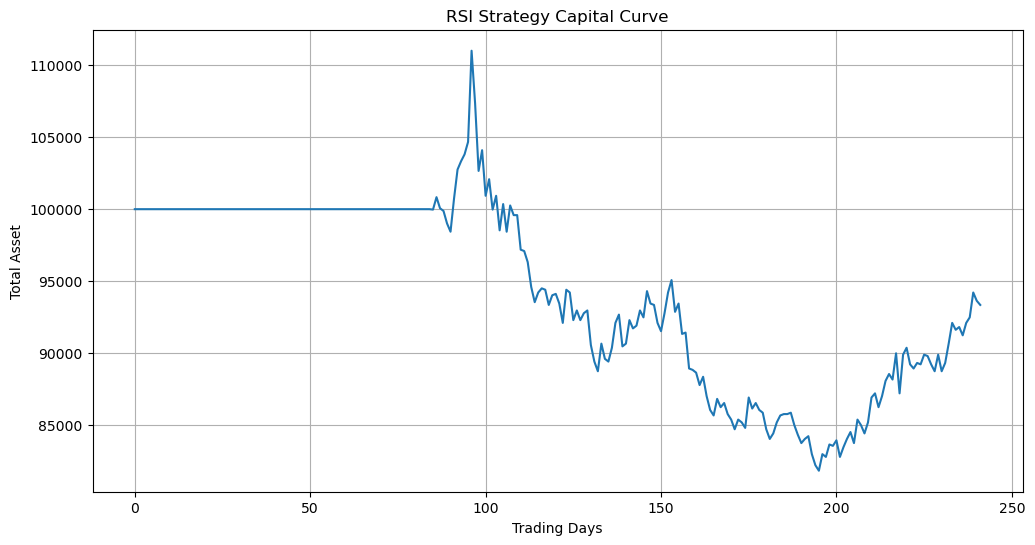

In [11]:
# 可视化资金曲线
plt.figure(figsize=(12,6))
plt.plot(capital_series)
plt.title('RSI Strategy Capital Curve')
plt.ylabel('Total Asset')
plt.xlabel('Trading Days')
plt.grid(True)
plt.show()

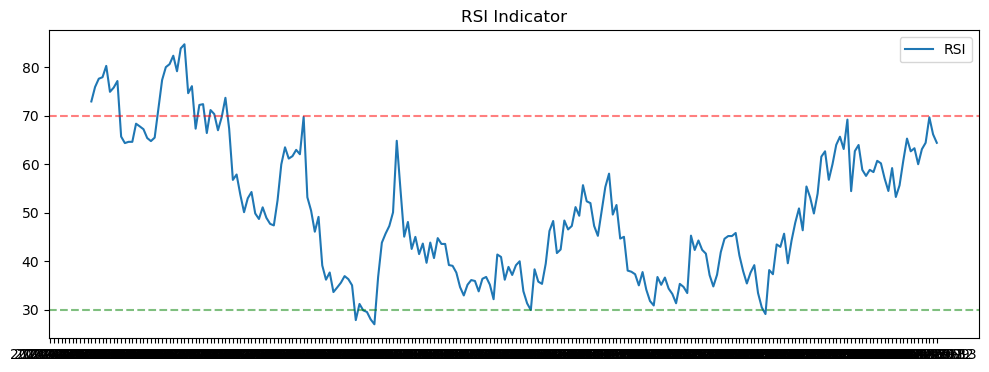

In [12]:
# 可选：绘制RSI指标
plt.figure(figsize=(12,4))
plt.plot(df['trade_date'], df['RSI'], label='RSI')
plt.axhline(70, linestyle='--', color='r', alpha=0.5)
plt.axhline(30, linestyle='--', color='g', alpha=0.5)
plt.title('RSI Indicator')
plt.legend()
plt.show()